In [1]:
import scipy.stats as ss
import pandas as pd
import numpy as np
import os
import h5py

# Convert GCTX to dataframe
def gctx_to_df(file):
    gfile = h5py.File(file, "r")
    df = pd.DataFrame(gfile['0/DATA/0/matrix'][:])

    # Get the row and column labels
    column_labels = [x.decode('utf-8') for x in list(gfile["0/META/ROW/id"])]
    row_labels = [x.decode('utf-8') for x in list(gfile["0/META/COL/id"])]
    gfile.close()
    
    df.index = row_labels
    df.columns = column_labels
    return df

# Input rank of zscore profile, and positions of up and down regulated genes to calculate ES score
def calc_ES(zscorerank,qup,qdown):
    n = len(zscorerank)
    nu = len(qup)
    nd = len(qdown)

    uptemp = np.array(sorted(zscorerank[qup]))
    downtemp = np.array(sorted(zscorerank[qdown]))
    upmax = max(np.array(range(1, nu+1))/nu - uptemp/n)
    upmin = min(np.array(range(0, nu))/nu - (uptemp - 1)/n)
    downmax = max(np.array(range(1, nd+1))/nd - downtemp/n)
    downmin = min(np.array(range(0, nd))/nd - (downtemp - 1)/n)

    upscore = (upmax if abs(upmax) > abs(upmin) else upmin)
    downscore = (downmax if abs(downmax) > abs(downmin) else downmin)

    ES= ((downscore - upscore)/2 if(upscore*downscore < 0) else 0)
    
    return ES

In [2]:
# Load in up and down genes and expressions
DATE = '08272023'
NAME = 'MRGvsM'
SELSET_FILE = './data/Rat_info_072023/MRGvsM_atp0.05_312.csv' # Replace with selected set file
G_FILE = './data/sigcom-lincs-L1000toRNAseq/Level5_pred_RNA-Seq-like-L1000/LINCS_DCIC_2021_AntibodyPert_PredictedRNAseq_ChDir_Sigs.gctx'
selset = pd.read_csv(SELSET_FILE, index_col=0)
gfile = h5py.File(G_FILE, "r")
P_FILTER = 0.01 # Filter for p-value on data

# Directory with level 5 data
L5_dir = '/home/jrollins/home/data/sigcom-lincs-L1000toRNAseq/Level5_pred_RNA-Seq-like-L1000/' # Change to location of level 5 sigcom data or substitute

# Define output
OUTPUT_DIRECTORY = './data/Rat_info_072023/MRGvsM_results_08272023/'
if not os.path.exists(OUTPUT_DIRECTORY):
    os.mkdir(OUTPUT_DIRECTORY)

# Get just the gene list from the smallest file
l1000_genes = [x.decode('utf-8') for x in list(gfile["0/META/ROW/id"])]
m_genes = [x.upper() for x in selset.index]

# Print gene counts
print('Genes in Comparison set', len(l1000_genes))
print('Up and down regulated selected genes:', len(set(m_genes)))
print("Up and down regulated selected x L1000 genes:", len(set(m_genes).intersection(set(l1000_genes))))
print('\nIntersection of selected and L1000 gene names:',set(m_genes).intersection(set(l1000_genes)))

# Insert genes as a column instead of index to apply uppercase function
selset.insert(1, 'gene', selset.index)
selset['gene'] = selset['gene'].apply(str.upper)

# Take L1000 included genes
l1000_selset = selset[selset['gene'].isin(list(l1000_genes))]
l1000_selset = l1000_selset.reset_index()
l1000_selset.head(2)

# Filter by p-value
l1000_selset = l1000_selset[l1000_selset['PValue'] < P_FILTER]

# Separate the up and down regulated genes / indices for those genes
l1000_up = list(l1000_selset['gene'][l1000_selset['Foldchange'] > 1])
l1000_down = list(l1000_selset['gene'][l1000_selset['Foldchange'] < -1])
print('\nTotal L1000 and selected columns intersection genes:',len(l1000_up + l1000_down))
print('\nUp regulated genes:',l1000_up)
print('\nDown regulated genes:',l1000_down)

rows_gene_ids = l1000_up + l1000_down

Genes in Comparison set 23614
Up and down regulated selected genes: 312
Up and down regulated selected x L1000 genes: 283

Intersection of selected and L1000 gene names: {'NDRG2', 'SFXN5', 'ANKRD10', 'VHL', 'UBXN2A', 'ENTPD2', 'PURB', 'PAQR8', 'TMTC2', 'COL9A2', 'CEP95', 'FERMT2', 'TMEM100', 'BET1', 'ALDOC', 'APBB3', 'ALDH5A1', 'SAMD5', 'CBS', 'CMBL', 'WSB1', 'SRSF5', 'PKHD1L1', 'CALB2', 'AURKB', 'LIX1', 'TBKBP1', 'HSD11B1', 'DRD5', 'MFSD2A', 'S100A16', 'NKX2-1', 'SCN5A', 'STAC2', 'TATDN3', 'GCSH', 'GPR37L1', 'SLC22A3', 'PHKB', 'RBM3', 'TTBK1', 'KCTD15', 'CROT', 'TSPAN12', 'MPZL2', 'BTBD17', 'FGFR3', 'PNP', 'TNFSF13', 'PRDX6', 'COL3A1', 'CNTNAP1', 'CHPT1', 'SCN9A', 'SLC38A6', 'GABRE', 'FNBP4', 'LYNX1', 'MTURN', 'OXCT1', 'PGM1', 'GFRA1', 'POU3F3', 'ANKRD40', 'TRANK1', 'RGS20', 'TTC27', 'GIGYF1', 'CACNA1I', 'ODF3B', 'CALN1', 'GSTA1', 'NADK2', 'TENM4', 'SMOX', 'SLC27A1', 'ATXN2L', 'HOMER2', 'SST', 'NKAIN4', 'MYO10', 'GPC5', 'TST', 'GNL2', 'CXCL14', 'MYH6', 'SLC5A7', 'OMD', 'ACACA', 'F3', 

# Combine all the gctx files as dataframe

In [3]:
# Combine all of the gctx files as dataframe
total_pt = []
file_names_with_paths = [os.path.join(L5_dir, file) for file in os.listdir(L5_dir) if os.path.isfile(os.path.join(L5_dir, file))]

if not os.path.exists(L5_dir + NAME + '_sigcom_L1000_minusChem.pkl'):
    # Leaving out chem for now L5_dir + 'LINCS_DCIC_2021_ChemicalPert_PredictedRNAseq_ChDir_Sigs.gctx',
    to_combine = [L5_dir + 'LINCS_DCIC_2021_CRISPRPert_PredictedRNAseq_ChDir_Sigs.gctx',
     L5_dir + 'LINCS_DCIC_2021_LigandPert_PredictedRNAseq_ChDir_Sigs.gctx',
     L5_dir + 'LINCS_DCIC_2021_shRNAPert_PredictedRNAseq_ChDir_Sigs.gctx',
     L5_dir + 'LINCS_DCIC_2021_AntibodyPert_PredictedRNAseq_ChDir_Sigs.gctx',
     L5_dir + 'LINCS_DCIC_2021_siRNAPert_PredictedRNAseq_ChDir_Sigs.gctx',
     L5_dir + 'LINCS_DCIC_2021_OverexpressionPert_PredictedRNAseq_ChDir_Sigs.gctx']

    for i in to_combine:
        print(i)
        curr_pt = gctx_to_df(i)

        # Filter the dataframe so it can be combined in manageable size
        cols_to_drop = curr_pt.columns.difference(rows_gene_ids)
        curr_pt_fil = curr_pt.drop(columns=cols_to_drop)
        total_pt.append(curr_pt_fil)
        del curr_pt, curr_pt_fil
        

    total_df = pd.concat(total_pt)

    # Save intermediate file without chemical perturbations included (to save space, this can be changed if large RAM is available)
    total_df.to_pickle(L5_dir + NAME + '_sigcom_L1000_minusChem.pkl')
else:
    print('File already found: ' + L5_dir + NAME + '_sigcom_L1000_minusChem.pkl')


# Get the metadata to make the process clear
print('Begin filtering chemical perturbations')
gfile = h5py.File(L5_dir + 'LINCS_DCIC_2021_ChemicalPert_PredictedRNAseq_ChDir_Sigs.gctx', "r")
row_labels = np.array(gfile["0/META/ROW/id"])
col_labels = np.array(gfile["0/META/COL/id"])
gfile.close()
row_labels = np.array([x.decode('utf-8') for x in row_labels])
col_labels = np.array([x.decode('utf-8') for x in col_labels])
rows_gene_ids_idx = np.where(np.isin(row_labels, rows_gene_ids))[0]



if not os.path.exists(L5_dir + NAME + '_expGene_L1000_chempert.pkl'):
    # Get the data filtered by genes
    mag = 100000 # Size of chunk to use for L1000 chemical perturbations

    for i in range(0, int(len(col_labels)/mag)+1):
        if os.path.exists(L5_dir + NAME + '_expGene_L1000_pt' + str(i) + '.pkl'):
            print('File already exists: ' + L5_dir + NAME + '_expGene_L1000_pt' + str(i) + '.pkl')
        else:
            print(i,'has begun')
            gfile = h5py.File(L5_dir + 'LINCS_DCIC_2021_ChemicalPert_PredictedRNAseq_ChDir_Sigs.gctx', "r")
            l1000 = gfile['0/DATA/0/matrix'][i*mag:(i+1)*mag, rows_gene_ids_idx]
            gfile.close()
            df = pd.DataFrame(l1000, columns=row_labels[rows_gene_ids_idx], index=col_labels[i*mag:(i+1)*mag])
            print(L5_dir + NAME + '_expGene_L1000_pt' + str(i) + '_.pkl saved!')
            df.to_pickle(L5_dir + NAME + '_expGene_L1000_pt' + str(i) + '.pkl')

    total_pt = []
    for i in range(0, int(len(col_labels)/mag)+1):
        curr_pt = pd.read_pickle(L5_dir + NAME + '_expGene_L1000_pt' + str(i) + '.pkl')
        total_pt.append(curr_pt)

    total_df = pd.concat(total_pt)
    total_df.to_pickle(L5_dir + NAME + '_expGene_L1000_chempert.pkl')
else:
    print('File already exists: ' + L5_dir + NAME + '_expGene_L1000_chempert.pkl')


# Combine the chem and non-chem perturbation files with filtered columns for MRGvsM x eL1000
chem = pd.read_pickle(L5_dir + NAME + '_expGene_L1000_chempert.pkl')
non_chem = pd.read_pickle(L5_dir + NAME + '_sigcom_L1000_minusChem.pkl')
t_df = pd.concat([chem, non_chem])
print('Saved to ' + L5_dir + 'sigcom_' + NAME + 'xeL1000_geneExp.pkl')
t_df.to_pickle(L5_dir + 'sigcom_' + NAME + 'xeL1000_geneExp.pkl')

File already found: /home/jrollins/home/data/sigcom-lincs-L1000toRNAseq/Level5_pred_RNA-Seq-like-L1000/MRGvsM_sigcom_L1000_minusChem.pkl
Begin filtering chemical perturbations
File already exists: /home/jrollins/home/data/sigcom-lincs-L1000toRNAseq/Level5_pred_RNA-Seq-like-L1000/MRGvsM_expGene_L1000_chempert.pkl
Saved to /home/jrollins/home/data/sigcom-lincs-L1000toRNAseq/Level5_pred_RNA-Seq-like-L1000/sigcom_MRGvsMxeL1000_geneExp.pkl


In [4]:
# Combine all of the gctx files as dataframe
# Get the correlations of the selset foldchange with eL1000 data
sel_col = l1000_selset[['gene', 'Foldchange']]
sel_col.index = sel_col['gene']
sel_col = sel_col.drop(columns='gene')
sel_col.to_csv(L5_dir + 'sel_col_' + NAME + 'xeL1000genes.csv') # Save out the selected column as csv for ease of viewing later

sel_col = pd.read_csv(L5_dir + 'sel_col_' + NAME + 'xeL1000genes.csv')
sel_col = sel_col[sel_col['gene'].isin(rows_gene_ids)].sort_values('gene').reset_index(drop=True)

In [5]:
# Make the rows genes for efficient comparison calculations
l1000T = pd.read_pickle(L5_dir + 'sigcom_' + NAME + 'xeL1000_geneExp.pkl').T.reset_index()
l1000T.index = l1000T['index']
l1000T = l1000T.iloc[:,1:]
l1000T = l1000T.sort_values('index')


In [6]:
# Get the data filtered by genes
mag = 100000

if os.path.exists(OUTPUT_DIRECTORY + NAME + 'xel1000_plt01_corr.pkl'):
    print('File already exists: ' + OUTPUT_DIRECTORY + NAME + 'xel1000_plt01_corr.pkl')
else:
    for i in range(0,int(l1000T.shape[1]/mag)+1):
        print(i,'has begun')
        if not os.path.exists(OUTPUT_DIRECTORY + NAME + 'xel1000_corr_plt01_pt'+str(i)+'_' + DATE + '.pkl'):
            expl1000_corr_selset = l1000T.iloc[:,i*mag:(i+1)*mag].corrwith(sel_col['Foldchange'], method='pearson')
            expl1000_corr_selset_s = l1000T.iloc[:,i*mag:(i+1)*mag].corrwith(sel_col['Foldchange'], method='spearman')
            # Combine correlations and rename columns
            expl1000corrselset = pd.DataFrame([expl1000_corr_selset,expl1000_corr_selset_s]).T
            expl1000corrselset = expl1000corrselset.sort_values(0, ascending=False).reset_index()
            expl1000corrselset = expl1000corrselset.rename(columns={'index': 'sig_id', 0: 'pearson', 1: 'spearman'})
            print('saved to ' + OUTPUT_DIRECTORY + NAME + 'xel1000_corr_plt01_pt'+str(i)+'_' + DATE + '.csv')
            expl1000corrselset.to_pickle(OUTPUT_DIRECTORY + NAME + 'xel1000_corr_plt01_pt'+str(i)+'_' + DATE + '.pkl')
        else:
            print('File already exists: ' + OUTPUT_DIRECTORY + NAME + 'xel1000_corr_plt01_pt'+str(i)+'_' + DATE + '.pkl')


    # Combine the data filtered by genes
    total_pd = []
    for i in range(0,int(l1000T.shape[1]/mag)+1):
        curr_pd = pd.read_pickle(OUTPUT_DIRECTORY + NAME + 'xel1000_corr_plt01_pt' + str(i) + '_' + DATE + '.pkl')
        total_pd.append(curr_pd)

    total_df = pd.concat(total_pd)
    total_df = total_df.drop_duplicates()
    total_df = total_df.dropna()
    total_df = total_df.sort_values('pearson').sort_values('pearson').reset_index(drop=True)
    total_df.to_pickle(OUTPUT_DIRECTORY + NAME + 'xel1000_plt01_corr_' + DATE + '.pkl')

0 has begun
File already exists: ./data/Rat_info_072023/MRGvsM_results_08272023/MRGvsMxel1000_corr_plt01_pt0_08272023.pkl
1 has begun
File already exists: ./data/Rat_info_072023/MRGvsM_results_08272023/MRGvsMxel1000_corr_plt01_pt1_08272023.pkl
2 has begun
File already exists: ./data/Rat_info_072023/MRGvsM_results_08272023/MRGvsMxel1000_corr_plt01_pt2_08272023.pkl
3 has begun
File already exists: ./data/Rat_info_072023/MRGvsM_results_08272023/MRGvsMxel1000_corr_plt01_pt3_08272023.pkl
4 has begun
File already exists: ./data/Rat_info_072023/MRGvsM_results_08272023/MRGvsMxel1000_corr_plt01_pt4_08272023.pkl
5 has begun
File already exists: ./data/Rat_info_072023/MRGvsM_results_08272023/MRGvsMxel1000_corr_plt01_pt5_08272023.pkl
6 has begun
File already exists: ./data/Rat_info_072023/MRGvsM_results_08272023/MRGvsMxel1000_corr_plt01_pt6_08272023.pkl
7 has begun
File already exists: ./data/Rat_info_072023/MRGvsM_results_08272023/MRGvsMxel1000_corr_plt01_pt7_08272023.pkl
8 has begun
File already

In [7]:
# Calculate the ES score
# Make sure the right genes are aligned and filtered
sel_col = sel_col.reset_index()
sel_col = sel_col.sort_values('gene')
sel_up = sel_col['gene'][sel_col['Foldchange'] > 1].values
sel_down = sel_col['gene'][sel_col['Foldchange'] < -1].values


# get the index numbers of the up and down genes
qup = np.where(sel_col['gene'].isin(sel_up))[0]
qdown = np.where(sel_col['gene'].isin(sel_down))[0]

# make the rows ss.rankdata() and use qup and qdown
ES_scores = [l1000T.index, l1000T.apply(lambda x: calc_ES(ss.rankdata(x),qup,qdown), axis=0)]
ES_out = ES_scores[1].sort_values(ascending=False)
ES_out.to_pickle(OUTPUT_DIRECTORY + 'ES_' + NAME + 'xeL1000_plt01_'+ DATE +'.pkl')

df_ES = pd.DataFrame(ES_out, columns=['ES'])
df_ES = df_ES.reset_index().rename(columns={'index':'sig_id'})

Final output of enrichment score and correlation: ./data/Rat_info_072023/MRGvsM_results_08272023/MRGvsMxeL1000_corrES_plt01_08272023.pkl


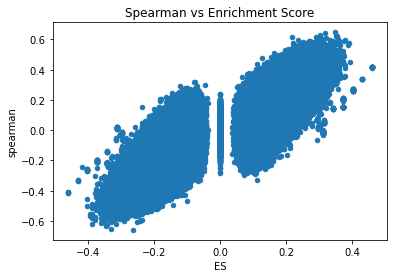

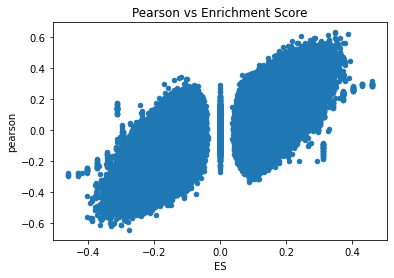

In [8]:
# Merge the ES scores and the correlations
df_corr = pd.read_pickle(OUTPUT_DIRECTORY + NAME + 'xel1000_plt01_corr_' + DATE + '.pkl')
df = pd.merge(df_corr, df_ES, on='sig_id', how='inner')
df = df.drop_duplicates().dropna().sort_values('pearson')


print('Final output of enrichment score and correlation: ' + OUTPUT_DIRECTORY + NAME + 'xeL1000_corrES_plt01_' + DATE + '.pkl')
df.to_pickle(OUTPUT_DIRECTORY + NAME + 'xeL1000_corrES_plt01_' + DATE + '.pkl')

ax = df.plot.scatter(x='ES', y='spearman', title='Spearman vs Enrichment Score')
fig = ax.get_figure()
fig.savefig(OUTPUT_DIRECTORY + NAME + 'spearmanvsES_plot.png')

ax = df.plot.scatter(x='ES', y='pearson', title='Pearson vs Enrichment Score')
fig = ax.get_figure()
fig.savefig(OUTPUT_DIRECTORY + NAME + 'pearsonvsES_plot.png')